# CMS Subtype Analysis by Treatment Response

This analysis examines the distribution of CMS subtypes (CMS1-4) among patients with PD (Progressive Disease) vs non-PD responses at pre-treatment and post-treatment time points.

---

## 1. Data Preparation

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
import os


os.chdir('../../')
os.getcwd()

# Load and prepare data
df = pd.read_csv("data/ann_with_cms.csv")

# Filter for analysis
analysis_df = df[
    (df['treatment.response'].isin(['PD', 'non-PD'])) & 
    (df['CMS'].isin(['CMS1', 'CMS2', 'CMS3', 'CMS4']))
].copy()

# Define color scheme
cms_colors = {
    'CMS1': '#FCAF2F',  # Orange
    'CMS2': '#00B0B6',  # Teal
    'CMS3': '#C964FF',  # Purple
    'CMS4': '#00C4F6'   # Blue
}

## 2. Pre-Treatment Analysis
Analysis of CMS distribution before treatment initiation.

CMS in pre-treatment data: ['CMS2' 'CMS3' 'CMS1' 'CMS4']


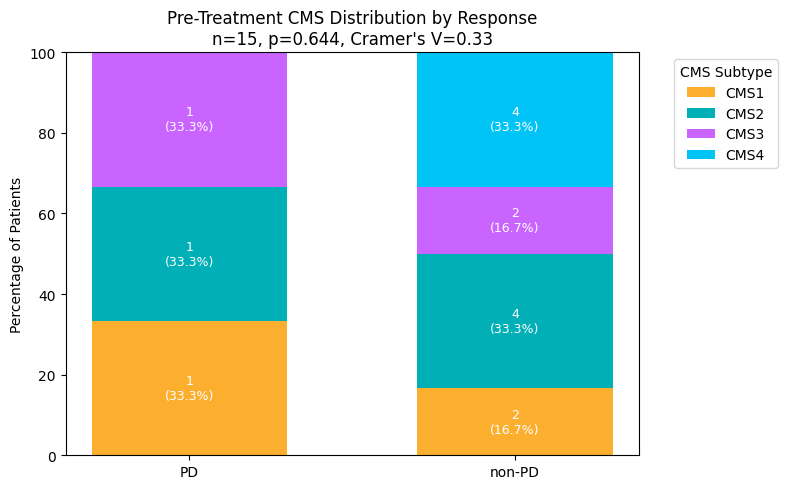

Contingency Table:


CMS,CMS1,CMS2,CMS3,CMS4
treatment.response,,,,
PD,1,1,1,0
non-PD,2,4,2,4


In [ ]:
# Subset pre-treatment data
pre_df = analysis_df[analysis_df['time.point'] == 'pre-treatment']
pre_counts = pd.crosstab(pre_df['treatment.response'], pre_df['CMS'])
pre_percent = pre_counts.div(pre_counts.sum(axis=1), axis=0) * 100

# Statistical testing
chi2_pre, p_pre, dof_pre, _ = chi2_contingency(pre_counts)
n_pre = pre_counts.sum().sum()
cramers_v_pre = np.sqrt(chi2_pre / (n_pre * (min(pre_counts.shape)-1)))

# Visualization
fig, ax = plt.subplots(figsize=(8,5))
bottom = np.zeros(len(pre_percent))

for cms in cms_colors:
    vals = pre_percent[cms].values
    ax.bar(pre_percent.index, vals, bottom=bottom, 
           label=cms, color=cms_colors[cms], width=0.6)
    
    # Add labels
    for i, (val, btm) in enumerate(zip(vals, bottom)):
        if val > 5:  # Only label visible segments
            count = pre_counts[cms].iloc[i]
            ax.text(i, btm + val/2, f"{count}\n({val:.1f}%)", 
                   ha='center', va='center', color='white', fontsize=9)
    bottom += vals

# Formatting
ax.set_ylabel('Percentage of Patients')
ax.set_title(f"Pre-Treatment CMS Distribution by Response\nn={n_pre}, p={p_pre:.3f}, Cramer's V={cramers_v_pre:.2f}")
ax.set_ylim(0, 100)
ax.legend(title='CMS Subtype', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Display counts
print("Contingency Table:")
display(pre_counts)

## 3. Post-Treatment Analysis
Analysis of CMS distribution after treatment.

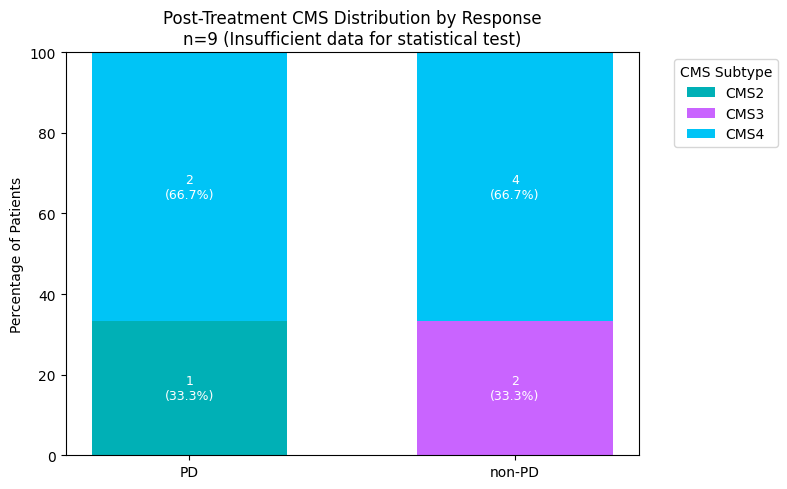

Contingency Table:


CMS,CMS1,CMS2,CMS3,CMS4
treatment.response,,,,
PD,0,1,0,2
non-PD,0,0,2,4



Note: Some cells have zero counts which may affect test validity
Note: Could not perform statistical test - insufficient data


In [7]:
# Subset post-treatment data
post_df = analysis_df[analysis_df['time.point'] == 'post-treatment']
post_counts = pd.crosstab(post_df['treatment.response'], post_df['CMS'])

# Ensure all CMS categories exist in the counts (even if zero counts)
for cms in cms_colors:
    if cms not in post_counts.columns:
        post_counts[cms] = 0  # Add missing CMS columns with zeros

# Reorder columns to match our color scheme
post_counts = post_counts[list(cms_colors.keys())]

# Calculate percentages
post_percent = post_counts.div(post_counts.sum(axis=1), axis=0) * 100

# Statistical testing with Fisher's exact fallback
try:
    if len(post_counts.columns) > 1 and len(post_counts.index) > 1:
        # Check if any expected frequencies < 5 (rule of thumb for chi-square)
        chi2, p, dof, expected = chi2_contingency(post_counts)
        if (expected < 5).any():
            print("Warning: Some expected frequencies < 5. Consider Fisher's exact test.")
        n_post = post_counts.sum().sum()
        cramers_v = np.sqrt(chi2 / (n_post * (min(post_counts.shape)-1)))
        test_used = "χ²"
    else:
        raise ValueError("Insufficient categories for chi-square test")
except (ValueError, ZeroDivisionError):
    from scipy.stats import fisher_exact
    try:
        if post_counts.shape == (2, 2):  # Fisher's exact only works for 2x2
            _, p = fisher_exact(post_counts)
            test_used = "Fisher's exact"
            cramers_v = np.nan
        else:
            raise ValueError("Table too large for Fisher's exact test")
    except ValueError:
        p = np.nan
        test_used = "No test (insufficient data)"
        cramers_v = np.nan

# Visualization
fig, ax = plt.subplots(figsize=(8,5))
bottom = np.zeros(len(post_percent))

# Only plot CMS subtypes that have non-zero values in any group
existing_cms = [cms for cms in cms_colors if post_counts[cms].sum() > 0]

for cms in existing_cms:
    vals = post_percent[cms].values
    ax.bar(post_percent.index, vals, bottom=bottom, 
           label=cms, color=cms_colors[cms], width=0.6)
    
    # Add labels only for non-zero values
    for i, (val, btm) in enumerate(zip(vals, bottom)):
        if val > 0:
            count = post_counts[cms].iloc[i]
            ax.text(i, btm + val/2, f"{count}\n({val:.1f}%)", 
                   ha='center', va='center', 
                   color='white' if val > 20 else 'black',
                   fontsize=9)
    bottom += vals

# Formatting
ax.set_ylabel('Percentage of Patients')
if not np.isnan(p):
    ax.set_title(f"Post-Treatment CMS Distribution by Response\nn={n_post}, {test_used} p={p:.3f}" + 
                 (f", Cramer's V={cramers_v:.2f}" if not np.isnan(cramers_v) else ""))
else:
    ax.set_title(f"Post-Treatment CMS Distribution by Response\nn={n_post} (Insufficient data for statistical test)")
    
ax.set_ylim(0, 100)
ax.legend(title='CMS Subtype', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Display counts with notes
print("Contingency Table:")
display(post_counts)

# Statistical notes
if (post_counts == 0).any().any():
    print("\nNote: Some cells have zero counts which may affect test validity")
if test_used == "Fisher's exact":
    print("Note: Used Fisher's exact test due to small sample sizes")
elif test_used == "No test (insufficient data)":
    print("Note: Could not perform statistical test - insufficient data")

## 4. Statistical Summary

Key findings from both analyses:

In [8]:
# Create summary dataframe
results = pd.DataFrame({
    'Time Point': ['Pre-Treatment', 'Post-Treatment'],
    'Sample Size': [n_pre, n_post],
    'Chi-Square': [chi2_pre, chi2_post],
    'Degrees of Freedom': [dof_pre, dof_post],
    'p-value': [p_pre, p_post],
    "Cramer's V": [cramers_v_pre, cramers_v_post]
}).set_index('Time Point')

# Formatting
styled_results = results.style.format({
    'p-value': '{:.3f}',
    "Cramer's V": '{:.2f}',
    'Chi-Square': '{:.1f}'
}).background_gradient(cmap='Blues', subset=['p-value'])

display(styled_results)

,Sample Size,Chi-Square,Degrees of Freedom,p-value,Cramer's V
Time Point,,,,,
Pre-Treatment,15,1.7,3,0.644,0.33
Post-Treatment,9,3.0,2,0.223,0.58
